In [1]:
from importlib import reload
import dataset as d; reload(d)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Load data

In [2]:
df = d.load_dataset()

In [3]:
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


## Create X and Y

In [4]:
PREDICTED_COLUMNS = ['radius_mean', 'diagnosis']
FEATURES = ['mean']

In [5]:
x, y = d.create_xy(df, FEATURES, PREDICTED_COLUMNS)

In [6]:
x = d.preprocess_data(x)

## Split Train, Val & Test

In [7]:
(x_train, y_train), (x_val, y_val), (x_test, y_test) = d.split_train_val_test(x, y, train_perc=0.6)

In [8]:
print('# Examples for training:', len(x_train))
print('# Examples for validation:', len(x_val))
print('# Examples for test:',  len(x_test))

# Examples for training: 214
# Examples for validation: 177
# Examples for test: 178


## Evaluate Features

### Covariance Matrix

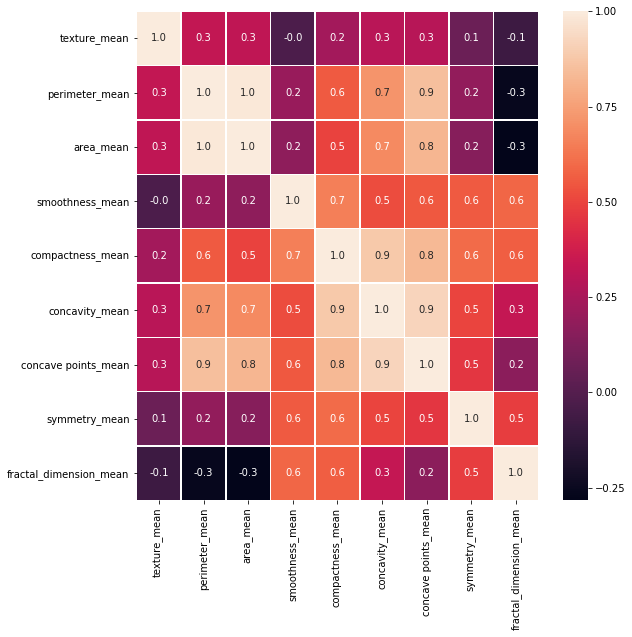

In [9]:
f, ax = plt.subplots(figsize=(x.shape[1], x.shape[1]))
sns.heatmap(x.corr(), annot=True, linewidths=.5, fmt= '.1f', ax=ax)

### PCA

In [10]:
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
basis = pca.fit(x_train)

In [11]:
x_train = basis.transform(x_train)
x_val = basis.transform(x_val)
x_test = basis.transform(x_test)

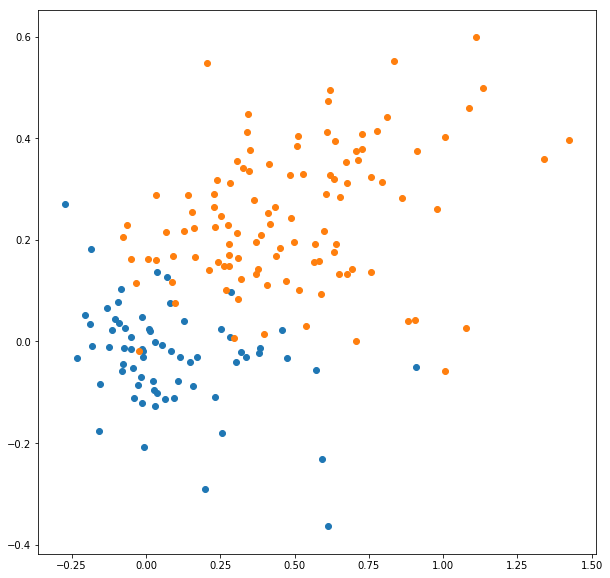

In [12]:
plt.figure(figsize=(10, 10))
plt.scatter(x_val[y_val[:, 1] == 'B', 0], x_val[y_val[:, 1] == 'B', 1])
plt.scatter(x_val[y_val[:, 1] == 'M', 0], x_val[y_val[:, 1] == 'M', 1])

## Ensemble of models

### Create an ensemble of models

In [13]:
import keras
from keras.layers import *
from keras.models import Model, Sequential
from keras.regularizers import l1_l2
from collections import defaultdict

c:\users\bearch\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [14]:
N_FEATURES = x_train.shape[1]

In [15]:
def create_base_model(input_size, n_hidden):
    i = Input((input_size, ))
    h = Dense(n_hidden, kernel_initializer='normal', use_bias=True, kernel_regularizer=l1_l2(l1=0.01, l2=0.01))(i)
    h = LeakyReLU()(h)
    o = Dense(1)(h)
    return Model(i, o)

In [16]:
models = []
N_MODELS = 5
n_hidden_neurons = 64
for _ in range(N_MODELS):
    models.append(create_base_model(N_FEATURES, n_hidden_neurons))

In [17]:
models[0].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 4)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                320       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 385
Trainable params: 385
Non-trainable params: 0
_________________________________________________________________


### Train ensemble

In [18]:
def train(model, train_data, val_data, lr, batch_size, epochs=50, history=None):
    current_epoch = 0 if history is None else len(history.history['loss'])
    model.compile(
        loss='mean_squared_error',
        optimizer=keras.optimizers.Adam(lr=lr),
        metrics=['mse']
    )
    
    new_history = model.fit(
        train_data[0], train_data[1], epochs=current_epoch+epochs,
        batch_size=batch_size,
        validation_data=val_data,
        initial_epoch=current_epoch,
        verbose=1
    )
    
    if history is not None:
        for key in new_history.history:
            history.history[key].extend(new_history.history[key])
    else:
        history = new_history
    
    return history

In [19]:
histories = defaultdict(lambda: None)

In [20]:
for lr in [0.5, 0.1, 0.05, 0.01]:
    for i in range(N_MODELS):
        histories[i] = train(models[i], [x_train, y_train[:, 0]], (x_val, y_val[:, 0]), 
                             lr, batch_size=300, epochs=80, history=histories[i])

Train on 214 samples, validate on 177 samples
Epoch 1/80
214/214 [==============================] - 3s 13ms/step - loss: 151.3601 - mean_squared_error: 151.2488 - val_loss: 69.0163 - val_mean_squared_error: 67.7126
Epoch 2/80
214/214 [==============================] - 0s 23us/step - loss: 37.0211 - mean_squared_error: 35.7175 - val_loss: 221.7164 - val_mean_squared_error: 219.4198
Epoch 3/80
214/214 [==============================] - 0s 28us/step - loss: 132.8675 - mean_squared_error: 130.5709 - val_loss: 5.5573 - val_mean_squared_error: 3.3620
Epoch 4/80
214/214 [==============================] - 0s 23us/step - loss: 4.8423 - mean_squared_error: 2.6470 - val_loss: 61.0008 - val_mean_squared_error: 59.0529
Epoch 5/80
214/214 [==============================] - 0s 23us/step - loss: 40.7843 - mean_squared_error: 38.8364 - val_loss: 104.1166 - val_mean_squared_error: 102.3317
Epoch 6/80
214/214 [==============================] - 0s 33us/step - loss: 67.7631 - mean_squared_error: 65.9783 - 

Epoch 51/80
214/214 [==============================] - 0s 23us/step - loss: 1.1564 - mean_squared_error: 0.3898 - val_loss: 0.9507 - val_mean_squared_error: 0.1988
Epoch 52/80
214/214 [==============================] - 0s 23us/step - loss: 1.0110 - mean_squared_error: 0.2591 - val_loss: 1.0684 - val_mean_squared_error: 0.3480
Epoch 53/80
214/214 [==============================] - 0s 23us/step - loss: 0.9696 - mean_squared_error: 0.2491 - val_loss: 1.3771 - val_mean_squared_error: 0.6910
Epoch 54/80
214/214 [==============================] - 0s 28us/step - loss: 1.0527 - mean_squared_error: 0.3667 - val_loss: 1.5112 - val_mean_squared_error: 0.8480
Epoch 55/80
214/214 [==============================] - 0s 19us/step - loss: 1.0296 - mean_squared_error: 0.3664 - val_loss: 1.3066 - val_mean_squared_error: 0.6515
Epoch 56/80
214/214 [==============================] - 0s 19us/step - loss: 0.9292 - mean_squared_error: 0.2742 - val_loss: 1.0396 - val_mean_squared_error: 0.3772
Epoch 57/80
214/

Epoch 21/80
214/214 [==============================] - 0s 28us/step - loss: 11.8943 - mean_squared_error: 10.8939 - val_loss: 1.4050 - val_mean_squared_error: 0.3620
Epoch 22/80
214/214 [==============================] - 0s 28us/step - loss: 1.3534 - mean_squared_error: 0.3104 - val_loss: 7.4540 - val_mean_squared_error: 6.4081
Epoch 23/80
214/214 [==============================] - 0s 23us/step - loss: 10.4016 - mean_squared_error: 9.3558 - val_loss: 7.7347 - val_mean_squared_error: 6.7852
Epoch 24/80
214/214 [==============================] - 0s 23us/step - loss: 5.1311 - mean_squared_error: 4.1816 - val_loss: 2.2781 - val_mean_squared_error: 1.4183
Epoch 25/80
214/214 [==============================] - 0s 23us/step - loss: 2.1922 - mean_squared_error: 1.3324 - val_loss: 5.2197 - val_mean_squared_error: 4.3807
Epoch 26/80
214/214 [==============================] - 0s 23us/step - loss: 7.8609 - mean_squared_error: 7.0218 - val_loss: 2.6903 - val_mean_squared_error: 1.8173
Epoch 27/80
2

Epoch 71/80
214/214 [==============================] - 0s 23us/step - loss: 0.7983 - mean_squared_error: 0.2514 - val_loss: 0.8318 - val_mean_squared_error: 0.2877
Epoch 72/80
214/214 [==============================] - 0s 28us/step - loss: 0.7646 - mean_squared_error: 0.2205 - val_loss: 0.7224 - val_mean_squared_error: 0.1848
Epoch 73/80
214/214 [==============================] - 0s 23us/step - loss: 0.7407 - mean_squared_error: 0.2031 - val_loss: 0.7221 - val_mean_squared_error: 0.1916
Epoch 74/80
214/214 [==============================] - 0s 19us/step - loss: 0.7747 - mean_squared_error: 0.2442 - val_loss: 0.7310 - val_mean_squared_error: 0.2110
Epoch 75/80
214/214 [==============================] - 0s 23us/step - loss: 0.7339 - mean_squared_error: 0.2139 - val_loss: 0.7867 - val_mean_squared_error: 0.2714
Epoch 76/80
214/214 [==============================] - 0s 28us/step - loss: 0.7294 - mean_squared_error: 0.2141 - val_loss: 0.8472 - val_mean_squared_error: 0.3260
Epoch 77/80
214/

Epoch 41/80
214/214 [==============================] - 0s 37us/step - loss: 1.0918 - mean_squared_error: 0.5290 - val_loss: 0.8579 - val_mean_squared_error: 0.2924
Epoch 42/80
214/214 [==============================] - 0s 47us/step - loss: 1.0731 - mean_squared_error: 0.5076 - val_loss: 1.3836 - val_mean_squared_error: 0.8173
Epoch 43/80
214/214 [==============================] - 0s 23us/step - loss: 1.6415 - mean_squared_error: 1.0752 - val_loss: 0.9753 - val_mean_squared_error: 0.4001
Epoch 44/80
214/214 [==============================] - 0s 47us/step - loss: 0.8626 - mean_squared_error: 0.2873 - val_loss: 1.0117 - val_mean_squared_error: 0.4329
Epoch 45/80
214/214 [==============================] - 0s 23us/step - loss: 1.1152 - mean_squared_error: 0.5365 - val_loss: 1.4453 - val_mean_squared_error: 0.8768
Epoch 46/80
214/214 [==============================] - 0s 37us/step - loss: 1.3592 - mean_squared_error: 0.7907 - val_loss: 0.8984 - val_mean_squared_error: 0.3486
Epoch 47/80
214/

Epoch 11/80
214/214 [==============================] - 0s 28us/step - loss: 6.6855 - mean_squared_error: 4.9749 - val_loss: 23.7801 - val_mean_squared_error: 22.2500
Epoch 12/80
214/214 [==============================] - 0s 23us/step - loss: 20.4180 - mean_squared_error: 18.8879 - val_loss: 13.6061 - val_mean_squared_error: 12.2683
Epoch 13/80
214/214 [==============================] - 0s 23us/step - loss: 14.2120 - mean_squared_error: 12.8742 - val_loss: 3.3259 - val_mean_squared_error: 2.1599
Epoch 14/80
214/214 [==============================] - 0s 28us/step - loss: 2.3981 - mean_squared_error: 1.2321 - val_loss: 15.2224 - val_mean_squared_error: 14.1470
Epoch 15/80
214/214 [==============================] - 0s 33us/step - loss: 16.4513 - mean_squared_error: 15.3760 - val_loss: 5.5083 - val_mean_squared_error: 4.4544
Epoch 16/80
214/214 [==============================] - 0s 47us/step - loss: 8.2212 - mean_squared_error: 7.1673 - val_loss: 3.5816 - val_mean_squared_error: 2.4806
Epoc

Epoch 61/80
214/214 [==============================] - 0s 23us/step - loss: 0.9286 - mean_squared_error: 0.2762 - val_loss: 1.4167 - val_mean_squared_error: 0.7625
Epoch 62/80
214/214 [==============================] - 0s 23us/step - loss: 0.9706 - mean_squared_error: 0.3164 - val_loss: 1.2075 - val_mean_squared_error: 0.5458
Epoch 63/80
214/214 [==============================] - 0s 33us/step - loss: 0.9405 - mean_squared_error: 0.2788 - val_loss: 0.9775 - val_mean_squared_error: 0.3103
Epoch 64/80
214/214 [==============================] - 0s 22us/step - loss: 0.8917 - mean_squared_error: 0.2245 - val_loss: 0.8770 - val_mean_squared_error: 0.2096
Epoch 65/80
214/214 [==============================] - 0s 23us/step - loss: 0.9099 - mean_squared_error: 0.2425 - val_loss: 0.8690 - val_mean_squared_error: 0.2156
Epoch 66/80
214/214 [==============================] - 0s 23us/step - loss: 0.9155 - mean_squared_error: 0.2620 - val_loss: 0.9317 - val_mean_squared_error: 0.2957
Epoch 67/80
214/

Epoch 31/80
214/214 [==============================] - 0s 23us/step - loss: 1.4847 - mean_squared_error: 0.6470 - val_loss: 4.5738 - val_mean_squared_error: 3.7350
Epoch 32/80
214/214 [==============================] - 0s 28us/step - loss: 2.2579 - mean_squared_error: 1.4190 - val_loss: 3.6363 - val_mean_squared_error: 2.7733
Epoch 33/80
214/214 [==============================] - 0s 28us/step - loss: 2.0319 - mean_squared_error: 1.1689 - val_loss: 1.7807 - val_mean_squared_error: 0.8743
Epoch 34/80
214/214 [==============================] - 0s 28us/step - loss: 1.2686 - mean_squared_error: 0.3622 - val_loss: 1.2021 - val_mean_squared_error: 0.2527
Epoch 35/80
214/214 [==============================] - 0s 23us/step - loss: 1.3918 - mean_squared_error: 0.4424 - val_loss: 1.4631 - val_mean_squared_error: 0.5052
Epoch 36/80
214/214 [==============================] - 0s 47us/step - loss: 1.8986 - mean_squared_error: 0.9407 - val_loss: 1.2883 - val_mean_squared_error: 0.3566
Epoch 37/80
214/

Train on 214 samples, validate on 177 samples
Epoch 81/160
214/214 [==============================] - 0s 2ms/step - loss: 0.7524 - mean_squared_error: 0.2096 - val_loss: 6.5551 - val_mean_squared_error: 6.0256
Epoch 82/160
214/214 [==============================] - 0s 28us/step - loss: 9.4364 - mean_squared_error: 8.9069 - val_loss: 0.8528 - val_mean_squared_error: 0.2968
Epoch 83/160
214/214 [==============================] - 0s 28us/step - loss: 0.8994 - mean_squared_error: 0.3434 - val_loss: 3.9259 - val_mean_squared_error: 3.3528
Epoch 84/160
214/214 [==============================] - 0s 33us/step - loss: 4.0662 - mean_squared_error: 3.4932 - val_loss: 6.2761 - val_mean_squared_error: 5.6909
Epoch 85/160
214/214 [==============================] - 0s 51us/step - loss: 6.1446 - mean_squared_error: 5.5593 - val_loss: 4.3161 - val_mean_squared_error: 3.7225
Epoch 86/160
214/214 [==============================] - 0s 37us/step - loss: 3.8816 - mean_squared_error: 3.2880 - val_loss: 1.611

Epoch 131/160
214/214 [==============================] - 0s 28us/step - loss: 0.6763 - mean_squared_error: 0.2351 - val_loss: 0.6236 - val_mean_squared_error: 0.1849
Epoch 132/160
214/214 [==============================] - 0s 22us/step - loss: 0.6628 - mean_squared_error: 0.2242 - val_loss: 0.6324 - val_mean_squared_error: 0.1931
Epoch 133/160
214/214 [==============================] - 0s 23us/step - loss: 0.6416 - mean_squared_error: 0.2024 - val_loss: 0.6573 - val_mean_squared_error: 0.2170
Epoch 134/160
214/214 [==============================] - 0s 28us/step - loss: 0.6369 - mean_squared_error: 0.1966 - val_loss: 0.6823 - val_mean_squared_error: 0.2397
Epoch 135/160
214/214 [==============================] - 0s 28us/step - loss: 0.6484 - mean_squared_error: 0.2057 - val_loss: 0.6838 - val_mean_squared_error: 0.2401
Epoch 136/160
214/214 [==============================] - 0s 23us/step - loss: 0.6512 - mean_squared_error: 0.2076 - val_loss: 0.6606 - val_mean_squared_error: 0.2192
Epoc

Epoch 101/160
214/214 [==============================] - 0s 28us/step - loss: 1.0333 - mean_squared_error: 0.5274 - val_loss: 0.8337 - val_mean_squared_error: 0.3256
Epoch 102/160
214/214 [==============================] - 0s 23us/step - loss: 0.6970 - mean_squared_error: 0.1888 - val_loss: 1.4035 - val_mean_squared_error: 0.8965
Epoch 103/160
214/214 [==============================] - 0s 23us/step - loss: 0.9972 - mean_squared_error: 0.4903 - val_loss: 1.9756 - val_mean_squared_error: 1.4724
Epoch 104/160
214/214 [==============================] - 0s 23us/step - loss: 1.4206 - mean_squared_error: 0.9174 - val_loss: 1.9975 - val_mean_squared_error: 1.5017
Epoch 105/160
214/214 [==============================] - 0s 23us/step - loss: 1.4318 - mean_squared_error: 0.9360 - val_loss: 1.5135 - val_mean_squared_error: 1.0227
Epoch 106/160
214/214 [==============================] - 0s 28us/step - loss: 1.0515 - mean_squared_error: 0.5606 - val_loss: 0.9839 - val_mean_squared_error: 0.4964
Epoc

Epoch 151/160
214/214 [==============================] - 0s 28us/step - loss: 0.6330 - mean_squared_error: 0.1911 - val_loss: 0.8476 - val_mean_squared_error: 0.4069
Epoch 152/160
214/214 [==============================] - 0s 33us/step - loss: 0.6366 - mean_squared_error: 0.1959 - val_loss: 0.8274 - val_mean_squared_error: 0.3874
Epoch 153/160
214/214 [==============================] - 0s 23us/step - loss: 0.6349 - mean_squared_error: 0.1949 - val_loss: 0.7877 - val_mean_squared_error: 0.3467
Epoch 154/160
214/214 [==============================] - 0s 23us/step - loss: 0.6301 - mean_squared_error: 0.1891 - val_loss: 0.7526 - val_mean_squared_error: 0.3120
Epoch 155/160
214/214 [==============================] - 0s 19us/step - loss: 0.6269 - mean_squared_error: 0.1863 - val_loss: 0.7365 - val_mean_squared_error: 0.2982
Epoch 156/160
214/214 [==============================] - 0s 23us/step - loss: 0.6275 - mean_squared_error: 0.1893 - val_loss: 0.7395 - val_mean_squared_error: 0.3036
Epoc

Epoch 121/160
214/214 [==============================] - 0s 28us/step - loss: 0.6176 - mean_squared_error: 0.2098 - val_loss: 0.7558 - val_mean_squared_error: 0.3444
Epoch 122/160
214/214 [==============================] - 0s 23us/step - loss: 0.6762 - mean_squared_error: 0.2647 - val_loss: 0.7282 - val_mean_squared_error: 0.3070
Epoch 123/160
214/214 [==============================] - 0s 23us/step - loss: 0.6833 - mean_squared_error: 0.2620 - val_loss: 0.6350 - val_mean_squared_error: 0.2070
Epoch 124/160
214/214 [==============================] - 0s 19us/step - loss: 0.6251 - mean_squared_error: 0.1971 - val_loss: 0.5981 - val_mean_squared_error: 0.1679
Epoch 125/160
214/214 [==============================] - 0s 28us/step - loss: 0.6058 - mean_squared_error: 0.1756 - val_loss: 0.6148 - val_mean_squared_error: 0.1894
Epoch 126/160
214/214 [==============================] - 0s 28us/step - loss: 0.6428 - mean_squared_error: 0.2174 - val_loss: 0.6068 - val_mean_squared_error: 0.1902
Epoc

Epoch 91/160
214/214 [==============================] - 0s 28us/step - loss: 2.0256 - mean_squared_error: 1.4636 - val_loss: 0.8440 - val_mean_squared_error: 0.3000
Epoch 92/160
214/214 [==============================] - 0s 23us/step - loss: 0.8698 - mean_squared_error: 0.3259 - val_loss: 1.8639 - val_mean_squared_error: 1.3324
Epoch 93/160
214/214 [==============================] - 0s 23us/step - loss: 1.1358 - mean_squared_error: 0.6043 - val_loss: 3.4889 - val_mean_squared_error: 2.9551
Epoch 94/160
214/214 [==============================] - 0s 28us/step - loss: 2.0370 - mean_squared_error: 1.5033 - val_loss: 3.7973 - val_mean_squared_error: 3.2479
Epoch 95/160
214/214 [==============================] - 0s 37us/step - loss: 2.3188 - mean_squared_error: 1.7694 - val_loss: 2.6365 - val_mean_squared_error: 2.0648
Epoch 96/160
214/214 [==============================] - 0s 23us/step - loss: 1.7623 - mean_squared_error: 1.1906 - val_loss: 1.2464 - val_mean_squared_error: 0.6547
Epoch 97/1

Epoch 141/160
214/214 [==============================] - 0s 28us/step - loss: 0.6687 - mean_squared_error: 0.2050 - val_loss: 0.6400 - val_mean_squared_error: 0.1800
Epoch 142/160
214/214 [==============================] - 0s 23us/step - loss: 0.6631 - mean_squared_error: 0.2031 - val_loss: 0.6458 - val_mean_squared_error: 0.1896
Epoch 143/160
214/214 [==============================] - 0s 23us/step - loss: 0.6526 - mean_squared_error: 0.1964 - val_loss: 0.6655 - val_mean_squared_error: 0.2142
Epoch 144/160
214/214 [==============================] - 0s 28us/step - loss: 0.6478 - mean_squared_error: 0.1965 - val_loss: 0.6876 - val_mean_squared_error: 0.2407
Epoch 145/160
214/214 [==============================] - 0s 23us/step - loss: 0.6491 - mean_squared_error: 0.2022 - val_loss: 0.6840 - val_mean_squared_error: 0.2386
Epoch 146/160
214/214 [==============================] - 0s 28us/step - loss: 0.6475 - mean_squared_error: 0.2021 - val_loss: 0.6622 - val_mean_squared_error: 0.2171
Epoc

Epoch 111/160
214/214 [==============================] - 0s 23us/step - loss: 0.6339 - mean_squared_error: 0.1977 - val_loss: 0.7515 - val_mean_squared_error: 0.3201
Epoch 112/160
214/214 [==============================] - 0s 23us/step - loss: 0.6365 - mean_squared_error: 0.2051 - val_loss: 0.7613 - val_mean_squared_error: 0.3387
Epoch 113/160
214/214 [==============================] - 0s 28us/step - loss: 0.7576 - mean_squared_error: 0.3351 - val_loss: 0.7903 - val_mean_squared_error: 0.3774
Epoch 114/160
214/214 [==============================] - 0s 28us/step - loss: 0.7992 - mean_squared_error: 0.3863 - val_loss: 0.8180 - val_mean_squared_error: 0.4107
Epoch 115/160
214/214 [==============================] - 0s 28us/step - loss: 0.7040 - mean_squared_error: 0.2967 - val_loss: 0.9249 - val_mean_squared_error: 0.5198
Epoch 116/160
214/214 [==============================] - 0s 23us/step - loss: 0.6068 - mean_squared_error: 0.2018 - val_loss: 1.0758 - val_mean_squared_error: 0.6678
Epoc

Train on 214 samples, validate on 177 samples
Epoch 161/240
214/214 [==============================] - 1s 3ms/step - loss: 0.5764 - mean_squared_error: 0.1842 - val_loss: 3.3018 - val_mean_squared_error: 2.8569
Epoch 162/240
214/214 [==============================] - 0s 28us/step - loss: 2.3147 - mean_squared_error: 1.8699 - val_loss: 0.6046 - val_mean_squared_error: 0.1949
Epoch 163/240
214/214 [==============================] - 0s 33us/step - loss: 0.6222 - mean_squared_error: 0.2125 - val_loss: 1.8772 - val_mean_squared_error: 1.5074
Epoch 164/240
214/214 [==============================] - 0s 33us/step - loss: 1.2709 - mean_squared_error: 0.9010 - val_loss: 2.5112 - val_mean_squared_error: 2.1306
Epoch 165/240
214/214 [==============================] - 0s 37us/step - loss: 1.7307 - mean_squared_error: 1.3501 - val_loss: 1.4270 - val_mean_squared_error: 1.0240
Epoch 166/240
214/214 [==============================] - 0s 37us/step - loss: 1.1704 - mean_squared_error: 0.7674 - val_loss:

214/214 [==============================] - 0s 28us/step - loss: 0.5270 - mean_squared_error: 0.1782 - val_loss: 0.5359 - val_mean_squared_error: 0.1908
Epoch 211/240
214/214 [==============================] - 0s 33us/step - loss: 0.5199 - mean_squared_error: 0.1748 - val_loss: 0.5288 - val_mean_squared_error: 0.1880
Epoch 212/240
214/214 [==============================] - 0s 23us/step - loss: 0.5175 - mean_squared_error: 0.1767 - val_loss: 0.5316 - val_mean_squared_error: 0.1940
Epoch 213/240
214/214 [==============================] - 0s 23us/step - loss: 0.5201 - mean_squared_error: 0.1825 - val_loss: 0.5342 - val_mean_squared_error: 0.1974
Epoch 214/240
214/214 [==============================] - 0s 23us/step - loss: 0.5205 - mean_squared_error: 0.1836 - val_loss: 0.5262 - val_mean_squared_error: 0.1888
Epoch 215/240
214/214 [==============================] - 0s 23us/step - loss: 0.5156 - mean_squared_error: 0.1782 - val_loss: 0.5247 - val_mean_squared_error: 0.1849
Epoch 216/240
214/

Epoch 180/240
214/214 [==============================] - 0s 19us/step - loss: 0.9365 - mean_squared_error: 0.5152 - val_loss: 0.7501 - val_mean_squared_error: 0.3335
Epoch 181/240
214/214 [==============================] - 0s 28us/step - loss: 0.7888 - mean_squared_error: 0.3722 - val_loss: 0.7944 - val_mean_squared_error: 0.3774
Epoch 182/240
214/214 [==============================] - 0s 23us/step - loss: 0.6349 - mean_squared_error: 0.2179 - val_loss: 0.9644 - val_mean_squared_error: 0.5440
Epoch 183/240
214/214 [==============================] - 0s 23us/step - loss: 0.6340 - mean_squared_error: 0.2137 - val_loss: 1.1326 - val_mean_squared_error: 0.7082
Epoch 184/240
214/214 [==============================] - 0s 23us/step - loss: 0.7436 - mean_squared_error: 0.3192 - val_loss: 1.1588 - val_mean_squared_error: 0.7301
Epoch 185/240
214/214 [==============================] - 0s 23us/step - loss: 0.8041 - mean_squared_error: 0.3754 - val_loss: 1.0360 - val_mean_squared_error: 0.6057
Epoc

Epoch 230/240
214/214 [==============================] - 0s 23us/step - loss: 0.5565 - mean_squared_error: 0.1789 - val_loss: 0.7898 - val_mean_squared_error: 0.4125
Epoch 231/240
214/214 [==============================] - 0s 19us/step - loss: 0.5567 - mean_squared_error: 0.1795 - val_loss: 0.7838 - val_mean_squared_error: 0.4081
Epoch 232/240
214/214 [==============================] - 0s 28us/step - loss: 0.5542 - mean_squared_error: 0.1785 - val_loss: 0.7671 - val_mean_squared_error: 0.3926
Epoch 233/240
214/214 [==============================] - 0s 23us/step - loss: 0.5519 - mean_squared_error: 0.1774 - val_loss: 0.7654 - val_mean_squared_error: 0.3928
Epoch 234/240
214/214 [==============================] - 0s 23us/step - loss: 0.5513 - mean_squared_error: 0.1788 - val_loss: 0.7605 - val_mean_squared_error: 0.3904
Epoch 235/240
214/214 [==============================] - 0s 23us/step - loss: 0.5497 - mean_squared_error: 0.1796 - val_loss: 0.7593 - val_mean_squared_error: 0.3894
Epoc

Epoch 200/240
214/214 [==============================] - 0s 28us/step - loss: 0.6046 - mean_squared_error: 0.2251 - val_loss: 0.5629 - val_mean_squared_error: 0.1855
Epoch 201/240
214/214 [==============================] - 0s 33us/step - loss: 0.6010 - mean_squared_error: 0.2236 - val_loss: 0.5430 - val_mean_squared_error: 0.1670
Epoch 202/240
214/214 [==============================] - 0s 28us/step - loss: 0.5722 - mean_squared_error: 0.1962 - val_loss: 0.5473 - val_mean_squared_error: 0.1726
Epoch 203/240
214/214 [==============================] - 0s 28us/step - loss: 0.5564 - mean_squared_error: 0.1817 - val_loss: 0.5743 - val_mean_squared_error: 0.1995
Epoch 204/240
214/214 [==============================] - 0s 23us/step - loss: 0.5689 - mean_squared_error: 0.1942 - val_loss: 0.5948 - val_mean_squared_error: 0.2183
Epoch 205/240
214/214 [==============================] - 0s 28us/step - loss: 0.5849 - mean_squared_error: 0.2084 - val_loss: 0.5853 - val_mean_squared_error: 0.2076
Epoc

Epoch 170/240
214/214 [==============================] - 0s 28us/step - loss: 1.0696 - mean_squared_error: 0.6786 - val_loss: 0.6203 - val_mean_squared_error: 0.2219
Epoch 171/240
214/214 [==============================] - 0s 28us/step - loss: 0.7157 - mean_squared_error: 0.3173 - val_loss: 0.6145 - val_mean_squared_error: 0.2054
Epoch 172/240
214/214 [==============================] - 0s 23us/step - loss: 0.6064 - mean_squared_error: 0.1973 - val_loss: 0.8067 - val_mean_squared_error: 0.3878
Epoch 173/240
214/214 [==============================] - 0s 28us/step - loss: 0.7890 - mean_squared_error: 0.3700 - val_loss: 0.9453 - val_mean_squared_error: 0.5197
Epoch 174/240
214/214 [==============================] - 0s 33us/step - loss: 0.9356 - mean_squared_error: 0.5100 - val_loss: 0.8778 - val_mean_squared_error: 0.4524
Epoch 175/240
214/214 [==============================] - 0s 28us/step - loss: 0.8531 - mean_squared_error: 0.4276 - val_loss: 0.6984 - val_mean_squared_error: 0.2790
Epoc

Epoch 220/240
214/214 [==============================] - 0s 28us/step - loss: 0.5173 - mean_squared_error: 0.1729 - val_loss: 0.5205 - val_mean_squared_error: 0.1764
Epoch 221/240
214/214 [==============================] - 0s 23us/step - loss: 0.5175 - mean_squared_error: 0.1734 - val_loss: 0.5211 - val_mean_squared_error: 0.1776
Epoch 222/240
214/214 [==============================] - 0s 23us/step - loss: 0.5174 - mean_squared_error: 0.1739 - val_loss: 0.5176 - val_mean_squared_error: 0.1759
Epoch 223/240
214/214 [==============================] - 0s 19us/step - loss: 0.5152 - mean_squared_error: 0.1735 - val_loss: 0.5128 - val_mean_squared_error: 0.1738
Epoch 224/240
214/214 [==============================] - 0s 23us/step - loss: 0.5127 - mean_squared_error: 0.1737 - val_loss: 0.5074 - val_mean_squared_error: 0.1715
Epoch 225/240
214/214 [==============================] - 0s 28us/step - loss: 0.5114 - mean_squared_error: 0.1755 - val_loss: 0.5039 - val_mean_squared_error: 0.1702
Epoc

Epoch 190/240
214/214 [==============================] - 0s 37us/step - loss: 0.5747 - mean_squared_error: 0.2503 - val_loss: 0.8245 - val_mean_squared_error: 0.5020
Epoch 191/240
214/214 [==============================] - 0s 37us/step - loss: 0.5239 - mean_squared_error: 0.2014 - val_loss: 0.9047 - val_mean_squared_error: 0.5823
Epoch 192/240
214/214 [==============================] - 0s 33us/step - loss: 0.4968 - mean_squared_error: 0.1745 - val_loss: 1.0211 - val_mean_squared_error: 0.6986
Epoch 193/240
214/214 [==============================] - 0s 28us/step - loss: 0.5176 - mean_squared_error: 0.1951 - val_loss: 1.0999 - val_mean_squared_error: 0.7778
Epoch 194/240
214/214 [==============================] - 0s 23us/step - loss: 0.5444 - mean_squared_error: 0.2223 - val_loss: 1.0886 - val_mean_squared_error: 0.7655
Epoch 195/240
214/214 [==============================] - 0s 23us/step - loss: 0.5376 - mean_squared_error: 0.2146 - val_loss: 0.9931 - val_mean_squared_error: 0.6697
Epoc

Epoch 240/240
214/214 [==============================] - 0s 38us/step - loss: 0.4514 - mean_squared_error: 0.1689 - val_loss: 0.8053 - val_mean_squared_error: 0.5220
Train on 214 samples, validate on 177 samples
Epoch 241/320
214/214 [==============================] - 1s 3ms/step - loss: 0.4833 - mean_squared_error: 0.1692 - val_loss: 0.5334 - val_mean_squared_error: 0.2255
Epoch 242/320
214/214 [==============================] - 0s 23us/step - loss: 0.5087 - mean_squared_error: 0.2008 - val_loss: 0.5121 - val_mean_squared_error: 0.2041
Epoch 243/320
214/214 [==============================] - 0s 28us/step - loss: 0.4770 - mean_squared_error: 0.1690 - val_loss: 0.5697 - val_mean_squared_error: 0.2623
Epoch 244/320
214/214 [==============================] - 0s 28us/step - loss: 0.5036 - mean_squared_error: 0.1962 - val_loss: 0.5303 - val_mean_squared_error: 0.2255
Epoch 245/320
214/214 [==============================] - 0s 28us/step - loss: 0.4892 - mean_squared_error: 0.1844 - val_loss:

214/214 [==============================] - 0s 37us/step - loss: 0.4382 - mean_squared_error: 0.1654 - val_loss: 0.4775 - val_mean_squared_error: 0.2054
Epoch 290/320
214/214 [==============================] - 0s 33us/step - loss: 0.4375 - mean_squared_error: 0.1654 - val_loss: 0.4793 - val_mean_squared_error: 0.2078
Epoch 291/320
214/214 [==============================] - 0s 37us/step - loss: 0.4365 - mean_squared_error: 0.1650 - val_loss: 0.4816 - val_mean_squared_error: 0.2106
Epoch 292/320
214/214 [==============================] - 0s 42us/step - loss: 0.4357 - mean_squared_error: 0.1647 - val_loss: 0.4827 - val_mean_squared_error: 0.2122
Epoch 293/320
214/214 [==============================] - 0s 37us/step - loss: 0.4351 - mean_squared_error: 0.1647 - val_loss: 0.4818 - val_mean_squared_error: 0.2121
Epoch 294/320
214/214 [==============================] - 0s 23us/step - loss: 0.4342 - mean_squared_error: 0.1645 - val_loss: 0.4791 - val_mean_squared_error: 0.2104
Epoch 295/320
214/

Epoch 259/320
214/214 [==============================] - 0s 28us/step - loss: 0.5205 - mean_squared_error: 0.1733 - val_loss: 0.7982 - val_mean_squared_error: 0.4524
Epoch 260/320
214/214 [==============================] - 0s 28us/step - loss: 0.5225 - mean_squared_error: 0.1767 - val_loss: 0.8185 - val_mean_squared_error: 0.4742
Epoch 261/320
214/214 [==============================] - 0s 28us/step - loss: 0.5259 - mean_squared_error: 0.1815 - val_loss: 0.8090 - val_mean_squared_error: 0.4662
Epoch 262/320
214/214 [==============================] - 0s 28us/step - loss: 0.5231 - mean_squared_error: 0.1804 - val_loss: 0.7794 - val_mean_squared_error: 0.4379
Epoch 263/320
214/214 [==============================] - 0s 28us/step - loss: 0.5177 - mean_squared_error: 0.1763 - val_loss: 0.7496 - val_mean_squared_error: 0.4089
Epoch 264/320
214/214 [==============================] - 0s 28us/step - loss: 0.5166 - mean_squared_error: 0.1759 - val_loss: 0.7317 - val_mean_squared_error: 0.3911
Epoc

Epoch 309/320
214/214 [==============================] - 0s 28us/step - loss: 0.4746 - mean_squared_error: 0.1691 - val_loss: 0.7626 - val_mean_squared_error: 0.4576
Epoch 310/320
214/214 [==============================] - 0s 23us/step - loss: 0.4737 - mean_squared_error: 0.1688 - val_loss: 0.7547 - val_mean_squared_error: 0.4504
Epoch 311/320
214/214 [==============================] - 0s 23us/step - loss: 0.4729 - mean_squared_error: 0.1686 - val_loss: 0.7517 - val_mean_squared_error: 0.4483
Epoch 312/320
214/214 [==============================] - 0s 23us/step - loss: 0.4719 - mean_squared_error: 0.1685 - val_loss: 0.7579 - val_mean_squared_error: 0.4554
Epoch 313/320
214/214 [==============================] - 0s 28us/step - loss: 0.4710 - mean_squared_error: 0.1685 - val_loss: 0.7648 - val_mean_squared_error: 0.4631
Epoch 314/320
214/214 [==============================] - 0s 28us/step - loss: 0.4703 - mean_squared_error: 0.1685 - val_loss: 0.7685 - val_mean_squared_error: 0.4677
Epoc

214/214 [==============================] - 0s 56us/step - loss: 0.5123 - mean_squared_error: 0.1740 - val_loss: 0.5061 - val_mean_squared_error: 0.1683
Epoch 279/320
214/214 [==============================] - 0s 56us/step - loss: 0.5112 - mean_squared_error: 0.1734 - val_loss: 0.5051 - val_mean_squared_error: 0.1681
Epoch 280/320
214/214 [==============================] - 0s 28us/step - loss: 0.5094 - mean_squared_error: 0.1724 - val_loss: 0.5060 - val_mean_squared_error: 0.1699
Epoch 281/320
214/214 [==============================] - 0s 47us/step - loss: 0.5089 - mean_squared_error: 0.1728 - val_loss: 0.5075 - val_mean_squared_error: 0.1722
Epoch 282/320
214/214 [==============================] - 0s 37us/step - loss: 0.5092 - mean_squared_error: 0.1740 - val_loss: 0.5070 - val_mean_squared_error: 0.1724
Epoch 283/320
214/214 [==============================] - 0s 23us/step - loss: 0.5087 - mean_squared_error: 0.1741 - val_loss: 0.5049 - val_mean_squared_error: 0.1705
Epoch 284/320
214/

Epoch 248/320
214/214 [==============================] - 0s 28us/step - loss: 0.4928 - mean_squared_error: 0.1847 - val_loss: 0.4995 - val_mean_squared_error: 0.1901
Epoch 249/320
214/214 [==============================] - 0s 28us/step - loss: 0.4859 - mean_squared_error: 0.1765 - val_loss: 0.4948 - val_mean_squared_error: 0.1857
Epoch 250/320
214/214 [==============================] - 0s 33us/step - loss: 0.4755 - mean_squared_error: 0.1664 - val_loss: 0.4929 - val_mean_squared_error: 0.1861
Epoch 251/320
214/214 [==============================] - 0s 23us/step - loss: 0.4763 - mean_squared_error: 0.1695 - val_loss: 0.4903 - val_mean_squared_error: 0.1870
Epoch 252/320
214/214 [==============================] - 0s 23us/step - loss: 0.4824 - mean_squared_error: 0.1790 - val_loss: 0.4816 - val_mean_squared_error: 0.1813
Epoch 253/320
214/214 [==============================] - 0s 47us/step - loss: 0.4805 - mean_squared_error: 0.1802 - val_loss: 0.4728 - val_mean_squared_error: 0.1744
Epoc

Epoch 298/320
214/214 [==============================] - 0s 23us/step - loss: 0.4324 - mean_squared_error: 0.1645 - val_loss: 0.4594 - val_mean_squared_error: 0.1921
Epoch 299/320
214/214 [==============================] - 0s 28us/step - loss: 0.4317 - mean_squared_error: 0.1644 - val_loss: 0.4588 - val_mean_squared_error: 0.1923
Epoch 300/320
214/214 [==============================] - 0s 33us/step - loss: 0.4307 - mean_squared_error: 0.1642 - val_loss: 0.4585 - val_mean_squared_error: 0.1928
Epoch 301/320
214/214 [==============================] - 0s 28us/step - loss: 0.4299 - mean_squared_error: 0.1641 - val_loss: 0.4584 - val_mean_squared_error: 0.1935
Epoch 302/320
214/214 [==============================] - 0s 23us/step - loss: 0.4288 - mean_squared_error: 0.1640 - val_loss: 0.4581 - val_mean_squared_error: 0.1937
Epoch 303/320
214/214 [==============================] - 0s 23us/step - loss: 0.4281 - mean_squared_error: 0.1638 - val_loss: 0.4581 - val_mean_squared_error: 0.1945
Epoc

Epoch 268/320
214/214 [==============================] - 0s 65us/step - loss: 0.4317 - mean_squared_error: 0.1689 - val_loss: 0.8457 - val_mean_squared_error: 0.5833
Epoch 269/320
214/214 [==============================] - 0s 51us/step - loss: 0.4292 - mean_squared_error: 0.1667 - val_loss: 0.8205 - val_mean_squared_error: 0.5585
Epoch 270/320
214/214 [==============================] - 0s 47us/step - loss: 0.4269 - mean_squared_error: 0.1649 - val_loss: 0.7963 - val_mean_squared_error: 0.5351
Epoch 271/320
214/214 [==============================] - 0s 23us/step - loss: 0.4268 - mean_squared_error: 0.1656 - val_loss: 0.7865 - val_mean_squared_error: 0.5259
Epoch 272/320
214/214 [==============================] - 0s 28us/step - loss: 0.4277 - mean_squared_error: 0.1671 - val_loss: 0.7907 - val_mean_squared_error: 0.5305
Epoch 273/320
214/214 [==============================] - 0s 23us/step - loss: 0.4270 - mean_squared_error: 0.1669 - val_loss: 0.8035 - val_mean_squared_error: 0.5438
Epoc

Epoch 318/320
214/214 [==============================] - 0s 23us/step - loss: 0.3989 - mean_squared_error: 0.1621 - val_loss: 0.7671 - val_mean_squared_error: 0.5308
Epoch 319/320
214/214 [==============================] - 0s 33us/step - loss: 0.3982 - mean_squared_error: 0.1619 - val_loss: 0.7680 - val_mean_squared_error: 0.5324
Epoch 320/320
214/214 [==============================] - 0s 23us/step - loss: 0.3975 - mean_squared_error: 0.1620 - val_loss: 0.7724 - val_mean_squared_error: 0.5373


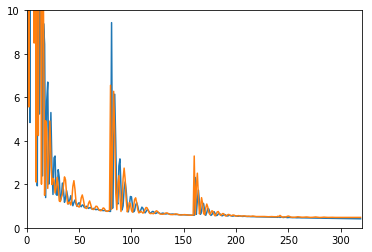

In [21]:
plt.plot(histories[0].history['loss'])
plt.plot(histories[0].history['val_loss'])
plt.axis([0, len(histories[0].history['loss']), 0, 10])
plt.show()

## Predict target feature using ensemble

In [22]:
y_train_preds = []
y_val_preds = []
y_test_preds = []

for model in models:
    y_train_preds.append(model.predict(x_train))
    y_val_preds.append(model.predict(x_val))
    y_test_preds.append(model.predict(x_test))

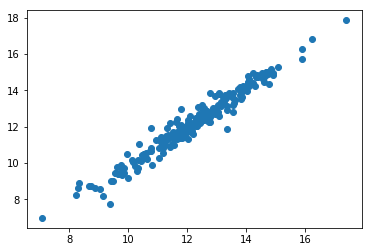

In [23]:
plt.scatter(np.mean(y_train_preds, axis=0), y_train[:, 0])
plt.show()

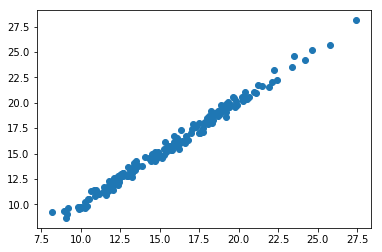

In [24]:
plt.scatter(np.mean(y_val_preds, axis=0), y_val[:, 0])
plt.show()

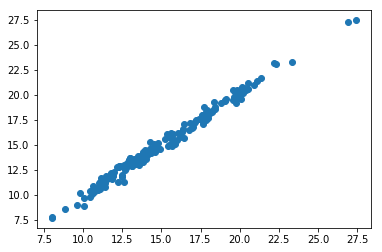

In [25]:
plt.scatter(np.mean(y_test_preds, axis=0), y_test[:, 0])
plt.show()

## Use ensemble variance to predict diagnosis 

In [26]:
y_train_preds_var = np.var(y_train_preds, axis=0)
y_val_preds_var = np.var(y_val_preds, axis=0)
y_test_preds_var = np.var(y_test_preds, axis=0)

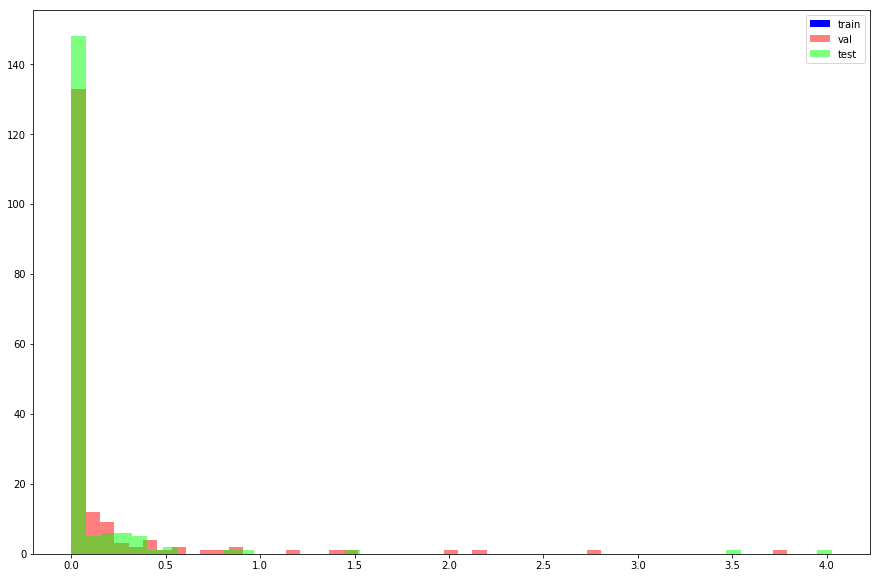

In [27]:
plt.figure(figsize=(15, 10))
plt.hist(y_train_preds_var, color='b',  bins=50, label='train')
plt.hist(y_val_preds_var, fc=(1, 0, 0, 0.5), bins=50, label='val')
plt.hist(y_test_preds_var, fc=(0, 1, 0, 0.5), bins=50, label='test')
plt.legend()
plt.show()

### Select variance threshold

In [28]:
def predict(y_preds_var, y, threshold):
    predictions = []
    
    for pred in y_preds_var:
            predictions.append(pred > threshold) 
    
    return predictions
    
def weighted_accuracy(y_preds_var, y, threshold):
    accs = []
    weights = []
    
    _, counts = np.unique(y[:, 1], return_counts=True)
    try:
        weight_b = counts[1]
        weight_m = counts[0]
    except:
        weight_b = 1
        weight_m = 1
    
    for i, pred in enumerate(y_preds_var):
        if y[i, 1] == 'B':
            accs.append(pred < threshold)
            weights.append(weight_b) 
        elif y[i, 1] == 'M':
            accs.append(pred > threshold)
            weights.append(weight_m)

    return np.average(accs, axis=0, weights=weights)[0] * 100

In [29]:
thresholds = np.linspace(0, 100, 500) *  y_train_preds_var.mean()
accs = []

for thr in thresholds:
    accs.append(weighted_accuracy(y_val_preds_var, y_val, thr))

threshold = thresholds[np.argmax(accs)]

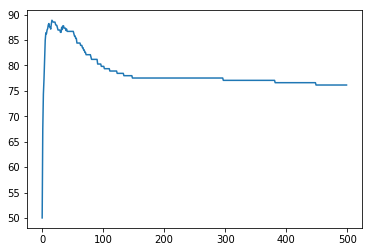

In [30]:
plt.plot(accs)
plt.show()

## Evaluation Metrics

In [31]:
print('Training Accuracy: %.1f%%' % weighted_accuracy(y_train_preds_var, y_train, threshold))

Training Accuracy: 92.5%


In [32]:
print('Validation Accuracy: %.1f%%' % weighted_accuracy(y_val_preds_var, y_val, threshold))

Validation Accuracy: 88.9%


In [33]:
print('Test Accuracy: %.1f%%' % weighted_accuracy(y_test_preds_var, y_test, threshold))

Test Accuracy: 88.1%


### Confusion Matrix

In [34]:
from sklearn.metrics import confusion_matrix

#### Validation

In [35]:
y_val_pred = predict(y_val_preds_var, y_val, threshold)
y_val_bool = [True if o == 'M' else False for o in y_val[:, 1]]

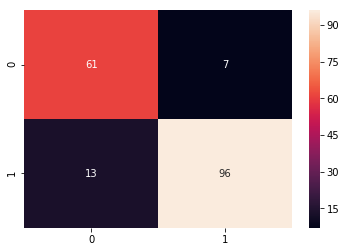

In [36]:
sns.heatmap(confusion_matrix(y_val_bool, y_val_pred), annot=True)

#### Test

In [37]:
y_test_pred = predict(y_test_preds_var, y_test, threshold)
y_test_bool = [True if o == 'M' else False for o in y_test[:, 1]]

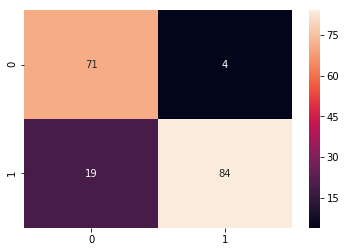

In [38]:
sns.heatmap(confusion_matrix(y_test_bool, y_test_pred), annot=True)

Done!